In [16]:
import nlp
import torch
import numpy as np
import scipy as sp
import io
import os
import torch
from tqdm.notebook import tqdm
from torch.utils.data import Dataset, DataLoader
from ml_things import plot_dict, plot_confusion_matrix, fix_text
from sklearn.metrics import classification_report, accuracy_score
from transformers import (set_seed,
                          TrainingArguments,
                          Trainer,
                          GPT2Config,
                          GPT2Tokenizer,
                          AdamW,
                          pipeline, 
                          get_linear_schedule_with_warmup,
                          GPT2ForSequenceClassification)

# Dictionary of labels and their id - this will be used to convert.
# String labels to number ids.
labels_ids = {'R': 0, 'D': 1}
id2label = {0: 'R', 1: 'D'}
# How many labels are we using in training.
# This is used to decide size of classification head.
n_labels = len(labels_ids)

# Look for gpu to use. Will use `cpu` by default if no gpu found.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

# Get model configuration.
print('Loading configuraiton...')
# model_config = GPT2Config.from_pretrained(pretrained_model_name_or_path='model/gpt2-text-classifier-model-no-fc', num_labels=n_labels,  label2id=labels_ids)

# Get model's tokenizer.
print('Loading tokenizer...')
tokenizer = GPT2Tokenizer.from_pretrained(pretrained_model_name_or_path='gpt2')
# default to left padding
tokenizer.padding_side = "left"
# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token


# Get the actual model.
print('Loading model...')
# model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='model/gpt2-text-classifier-model-no-fc', config=model_config)
model = GPT2ForSequenceClassification.from_pretrained(pretrained_model_name_or_path='model/gpt2-text-classifier-model-no-fc', num_labels=n_labels, id2label=id2label, label2id=labels_ids)

# resize model embedding to match new tokenizer
model.resize_token_embeddings(len(tokenizer))

# fix model padding token id
model.config.pad_token_id = model.config.eos_token_id

# Load model to defined device.
model.to(device)
print('Model loaded to `%s`'%device)


Loading configuraiton...
Loading tokenizer...
Loading model...
Model loaded to `cpu`


In [2]:
from torch.utils.data import Dataset
import pandas as pd
import glob

files = ['../data/processed/hein-daily_106.csv', '../data/processed/hein-daily_107.csv',
'../data/processed/hein-daily_108.csv', '../data/processed/hein-daily_109.csv',
'../data/processed/hein-daily_110.csv', '../data/processed/hein-daily_111.csv',
'../data/processed/hein-daily_112.csv', '../data/processed/hein-daily_113.csv',
'../data/processed/hein-daily_114.csv']

def read_df():
    "Read csv into df"
    df = pd.DataFrame()
    for f in files:
        csv = pd.read_csv(f)
        df = df.append(csv)
    # df = pd.read_csv(path)
    shuffled_df = df.sample(frac=1).reset_index()
    return shuffled_df

def create_dataset(df):
    "Create df from csv"

    df_sliced = df[['speech','party']]
    df_sliced.columns = ['text', 'label']

    return df_sliced

def get_top_k_rows(df, k):
    "Get top k rows from df"
    df_R = df[df['party'] == 'R'].sample(n=int(k/2), random_state=123)
    df_D = df[df['party'] == 'D'].sample(n=k-int(k/2), random_state=123)
    df = pd.concat([df_R, df_D])
    df_k = df.sample(frac=1).reset_index()
    return df_k

def save_csv(df, path):
    "Save df to csv"
    df.to_csv(path, index=False)



C:\Users\Aman Varshney\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# df = pd_dataset[pd_dataset['speakerid'] == 119040]
# pd_dataset = df

In [3]:
df = read_df()


C:\Users\Aman Varshney\AppData\Local\Temp\ipykernel_25392\577215653.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
C:\Users\Aman Varshney\AppData\Local\Temp\ipykernel_25392\577215653.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
C:\Users\Aman Varshney\AppData\Local\Temp\ipykernel_25392\577215653.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
C:\Users\Aman Varshney\AppData\Local\Temp\ipykernel_25392\577215653.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(csv)
C:\Users\Aman Varshney\AppData\Local\Temp\ipykernel_25392\577215653.py:16: Futur

In [12]:
# use k according to your choice
df = get_top_k_rows(df, 2500)
save_csv(df, 'random_k.csv')
df = create_dataset(df)

KeyError: 'party'

In [11]:
df.value_counts('label')

label
D    500
R    500
dtype: int64

In [13]:
from datasets import Dataset
arrow_dataset = Dataset.from_pandas(df)

In [66]:
arrow_dataset


Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})

In [56]:
"""Explain Text Classification module"""
import shap
import pickle

from loguru import logger



class TextClassificationExplainer():
    """Explains Text Classification models using SHAP"""

    def __init__(
        self,
        # model_path: str = None,
        model: GPT2ForSequenceClassification = None,
        tokenizer: GPT2Tokenizer = None,
    ):
        self.model = model
        self.tokenizer = tokenizer
        labels = ['R', 'D']

        # build a pipeline object to do predictions
        self.pred = pipeline(
            "text-classification",
            model=model,
            tokenizer=tokenizer,
            device=0 if torch.cuda.is_available() else -1,
            max_length=128,
            padding=True,
            truncation=True,
            top_k=None,
        )
        logger.info("text classification pipeline loaded")

        self.explainer = shap.Explainer(self.pred)
        logger.info("text classification explainer loaded")

    def save_explainer_to_disk(self, filename_expl: str):
        """Save explainer to disk"""
        logger.info(f"Saving explainer to disk at {filename_expl}")
        # self.explainer.save(path)
        pickle.dump(self.explainer, open(filename_expl, 'wb'))
    
    def load_explainer_from_disk(self, filename_expl: str):
        """Load explainer from disk"""
        logger.info(f"Loading explainer from disk from {filename_expl}")
        return pickle.load(open(filename_expl, 'rb'))
        # return self.explainer
    
    def save_shape_values_to_disk(self, filename_sv: str, shap_values):
        """Save shap values to disk"""
        logger.info(f"Saving shap values to disk at {filename_sv}")
        pickle.dump(shap_values, open(filename_sv, 'wb'))
    
    def load_shape_values_from_disk(self, filename_sv: str):
        """Load shap values from disk"""
        logger.info(f"Loading shap values from disk from {filename_sv}")
        return pickle.load(open(filename_sv, 'rb'))

    def get_shap_values(self, inputs):
        """
        Explains predictions of inputs using SHAP Explainer
        """
        logger.debug(f"explaining output for : {inputs}")
        return self.explainer(inputs)

    def get_predictions(self, inputs):
        """Return predictions from model"""

        predictions = self.pred(inputs)
        return predictions
    
    def get_plots(self,shap_values):
        "Plot graph of predictions"

        # shap_values.display_data = labels

        logger.debug(f"Plotting graph")
        return shap.plots.text(shap_values)

    def get_plots_specific_class(self, shap_values, class_name):
        "Return plot of specific class for specific text input"

        return shap.plots.text(shap_values[:, :, class_name])
    
    def get_plots_specific_input(self, shap_values, index_no, class_name):
        "Return plot of specific class for specific text input"

        return shap.plots.text(shap_values[index_no, :, class_name])

    def get_bar_plots_for_specific_input(self, shap_values, index_no, class_name):
        "Return bar plot for specific class"

        return shap.plots.bar(shap_values[index_no,:,class_name], max_display=20)

    def get_bar_plots_specific_class(self, shap_values, class_name):
        "Return bar plot for specific class"

        return shap.plots.bar(shap_values[:,:,class_name].mean(0), order=shap.Explanation.argsort, max_display=20)
        


In [57]:
explainer = TextClassificationExplainer(model=model, tokenizer=tokenizer)

2023-02-03 23:19:18.823 | INFO     | __main__:__init__:33 - text classification pipeline loaded
2023-02-03 23:19:18.826 | INFO     | __main__:__init__:36 - text classification explainer loaded


In [58]:
s_ind = 124
# e_ind = len(arrow_dataset)
e_ind = 125

In [59]:
arrow_dataset[s_ind:e_ind]

{'text': ['I ask unanimous consent that all Members have 5 legislative days within which to revise and extend their remarks and submit extraneous materials for the RECORD on H. R. 324. as amended, currently under consideration.'],
 'label': ['R']}

In [60]:
shap_values = explainer.get_shap_values(arrow_dataset['text'][s_ind:e_ind])

2023-02-03 23:19:23.401 | DEBUG    | __main__:get_shap_values:64 - explaining output for : ['I ask unanimous consent that all Members have 5 legislative days within which to revise and extend their remarks and submit extraneous materials for the RECORD on H. R. 324. as amended, currently under consideration.']
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#dep

In [61]:
explainer.save_explainer_to_disk('explainer.sav')
explainer.save_shape_values_to_disk('shap_values.sav', shap_values)

2023-02-03 23:20:11.704 | INFO     | __main__:save_explainer_to_disk:40 - Saving explainer to disk at explainer.sav
2023-02-03 23:20:12.894 | INFO     | __main__:save_shape_values_to_disk:52 - Saving shap values to disk at shap_values.sav


In [ ]:
# def shap_save_to_disk(self):
#      print("Saving SHAP to .h5 file...")
#      h5_file = self.h5_file
#      shap_val_df = pd.DataFrame(self.shap_values) #this step is unnecessary, could just save np arrays directly, but the df have some advantages and I don't mind reconverting upon loading
#      shap_feat_df = pd.DataFrame(self.features_shap)
#      # define what goes in the first row with "d"
#      d = [[self.target, self.name_for_figs, self.shap_expected, self.class_thresh]]
#      exp_df = pd.DataFrame(
#           d, columns=("target", "name_for_figs", "shap_exp_val", "class_thresh")
#      )
#      shap_val_df.to_hdf(h5_file, key="shap_values", format="table")
#      shap_feat_df.to_hdf(h5_file, key="features_shap", format="table")
#      exp_df.to_hdf(h5_file, key="shap_expected_value", format="table")

In [23]:
(shap_values[0][0].values[1])

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

-0.007774928584694862

In [52]:
# identify the most impactful words
# here we are just finding words which are having impact on the prediction no matter positive or negative
# to find positive and negative impact words, we can use the shap_values values and do the mean on abs values and 
# then sort in ascending and descending order respectively
word_importance = {}
for i, text in enumerate(arrow_dataset['text'][s_ind:e_ind]):
    print(text)
    for j, word in enumerate(text.split()):
        if word not in word_importance:
            word_importance[word] = 0
        word_importance[word] += abs(shap_values[i][j].values[0])

# sort the words by importance
sorted_words = sorted(word_importance.items(), key=lambda x: x[1], reverse=True)

# print the most impactful words
print("Most Impactful Words:")
for word, importance in sorted_words[:20]:
    print("{}: {}".format(word, importance))

I ask unanimous consent that all Members have 5 legislative days within which to revise and extend their remarks and submit extraneous materials for the RECORD on H. R. 324. as amended, currently under consideration.
Most Impactful Words:
under: 0.07047200947999954
amended,: 0.020127151161432266
days: 0.018555444665253162
within: 0.017994713969528675
that: 0.01620086468756199
consideration.: 0.015857987105846405
5: 0.014525447972118855
ask: 0.013218574225902557
unanimous: 0.01241961121559143
on: 0.01181110433701958
currently: 0.01056944951415062
materials: 0.007941758260130882
R.: 0.007384594574215866
extend: 0.0069395797327160835
submit: 0.0069161271676421165
324.: 0.006148980974796272
and: 0.006052867509424686
H.: 0.0058878592348524505
all: 0.005339045077562332
I: 0.005296289920806885


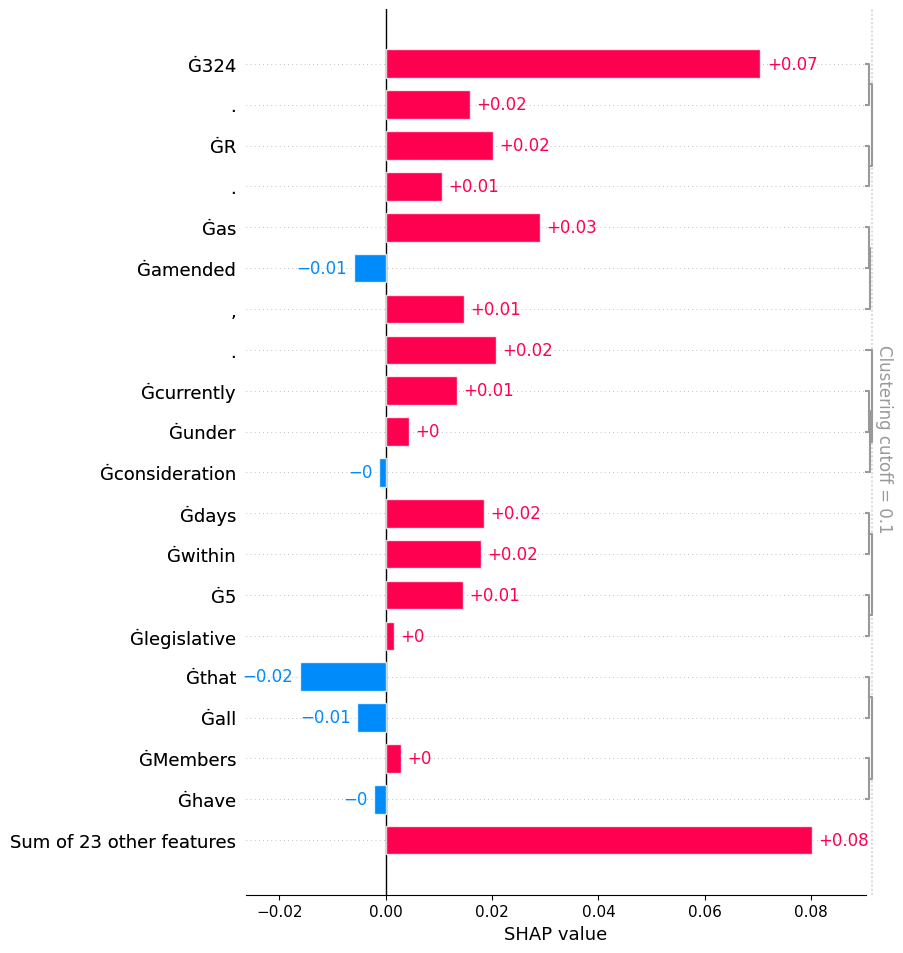

In [51]:
shap.plots.bar(shap_values[0,:,"R"], clustering_cutoff=0.1, max_display=20)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

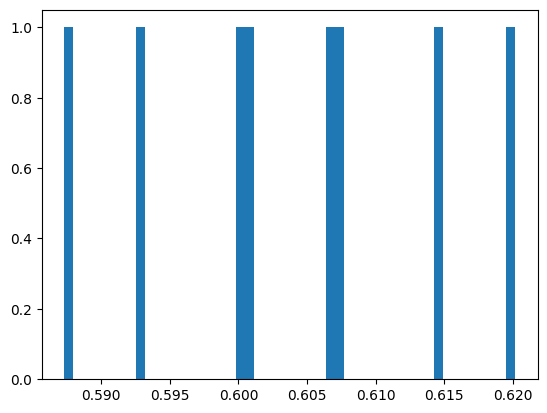

In [38]:
import matplotlib.pyplot as plt
# shap_values_numerical = [x.values[0] for x in shap_values]

# # plot the distribution of the SHAP values
# plt.hist(shap_values_numerical, bins=50)
# plt.show()

# just a try to Analyze the distribution of the SHAP values
shap_values_numerical = []
for explanation in shap_values:
    expected_value = explanation.values[1]
    raw = explanation.base_values[1]
    shap_values_numerical.extend(raw - expected_value)

# plot the distribution of the SHAP values
plt.hist(shap_values_numerical, bins=50)
plt.show()

In [46]:
# flatten the shap_values array
num_samples, num_features, num_outputs = shap_values.shape
flattened_shap_values = shap_values.reshape(num_samples * num_outputs, num_features)

# convert the flattened SHAP values into a pandas DataFrame
df = pd.DataFrame(flattened_shap_values)

# transpose the DataFrame to make each word a separate column
df = df.T

# calculate the mean absolute value of the SHAP values for each word
word_importance = df.abs().mean()

# sort the words by importance and select the top k positive words
k = 10
top_k_positive_words = word_importance.sort_values().head(k)

# sort the words by importance and select the top k negative words
top_k_negative_words = word_importance.sort_values(ascending=False).head(k)

print("The top {} positive words and phrases with the highest impact on the model's predictions:".format(k))
print(top_k_positive_words)

print("The top {} negative words and phrases with the highest impact on the model's predictions:".format(k))
print(top_k_negative_words)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


AttributeError: 'Explanation' object has no attribute 'reshape'

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

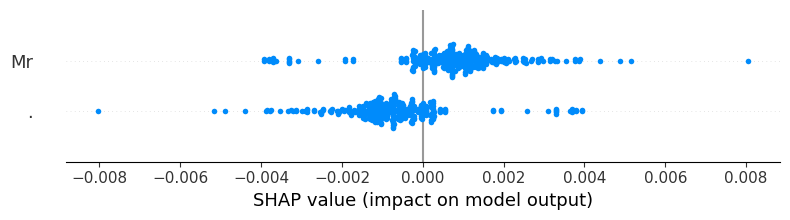

In [53]:
shap.summary_plot(shap_values[2], arrow_dataset['text'][s_ind:e_ind])

In [63]:
model.config

GPT2Config {
  "_name_or_path": "model/gpt2-text-classifier-model-no-fc",
  "activation_function": "gelu_new",
  "architectures": [
    "GPT2ForSequenceClassification"
  ],
  "attn_pdrop": 0.1,
  "bos_token_id": 50256,
  "embd_pdrop": 0.1,
  "eos_token_id": 50256,
  "id2label": {
    "0": "R",
    "1": "D"
  },
  "initializer_range": 0.02,
  "label2id": {
    "D": 1,
    "R": 0
  },
  "layer_norm_epsilon": 1e-05,
  "model_type": "gpt2",
  "n_ctx": 1024,
  "n_embd": 768,
  "n_head": 12,
  "n_inner": null,
  "n_layer": 12,
  "n_positions": 1024,
  "pad_token_id": 50256,
  "problem_type": "single_label_classification",
  "reorder_and_upcast_attn": false,
  "resid_pdrop": 0.1,
  "scale_attn_by_inverse_layer_idx": false,
  "scale_attn_weights": true,
  "summary_activation": null,
  "summary_first_dropout": 0.1,
  "summary_proj_to_labels": true,
  "summary_type": "cls_index",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_

In [90]:
(shap_values[1].values)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

array([[ 0.01641303, -0.01641303],
       [ 0.01641924, -0.01641926],
       [ 0.06171058, -0.06171058],
       [ 0.00359251, -0.0035925 ],
       [ 0.01331765, -0.01331765],
       [ 0.03019802, -0.03019802],
       [ 0.01003573, -0.01003573],
       [ 0.02634147, -0.02634148],
       [ 0.00591424, -0.00591424],
       [-0.01572824,  0.01572824],
       [-0.00701552,  0.00701552],
       [-0.00718724,  0.00718724],
       [-0.00092336,  0.00092334],
       [ 0.01838068, -0.01838069],
       [ 0.0084217 , -0.0084217 ],
       [ 0.01025854, -0.01025854],
       [ 0.03235202, -0.03235202],
       [-0.00674631,  0.00674629],
       [ 0.02132264, -0.02132263],
       [ 0.00296683, -0.00296684],
       [-0.00132868,  0.00132868],
       [ 0.00712348, -0.00712347],
       [ 0.04041429, -0.04041427],
       [ 0.00043819, -0.00043819],
       [ 0.00149599, -0.00149599],
       [ 0.00496853, -0.00496853],
       [ 0.00807337, -0.00807337],
       [ 0.01192995, -0.01192995],
       [ 0.01056935,

In [63]:
model_predictions = explainer.get_predictions(arrow_dataset['text'][s_ind:e_ind])


2023-02-03 23:20:43.072 | INFO     | __main__:load_explainer_from_disk:46 - Loading explainer from disk from explainer.sav


In [64]:
model_predictions

[[{'label': 'R', 'score': 0.915343701839447},
  {'label': 'D', 'score': 0.08465630561113358}]]

In [65]:
explainer.get_plots(shap_values)

2023-02-03 23:22:29.549 | DEBUG    | __main__:get_plots:78 - Plotting graph


In [66]:
explainer.get_plots_specific_input(shap_values, 2, "R")


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

In [ ]:
explainer.get_plots_specific_class(shap_values,12,"R")

In [ ]:
explainer.get_plots_specific_class(shap_values,12,"D")

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

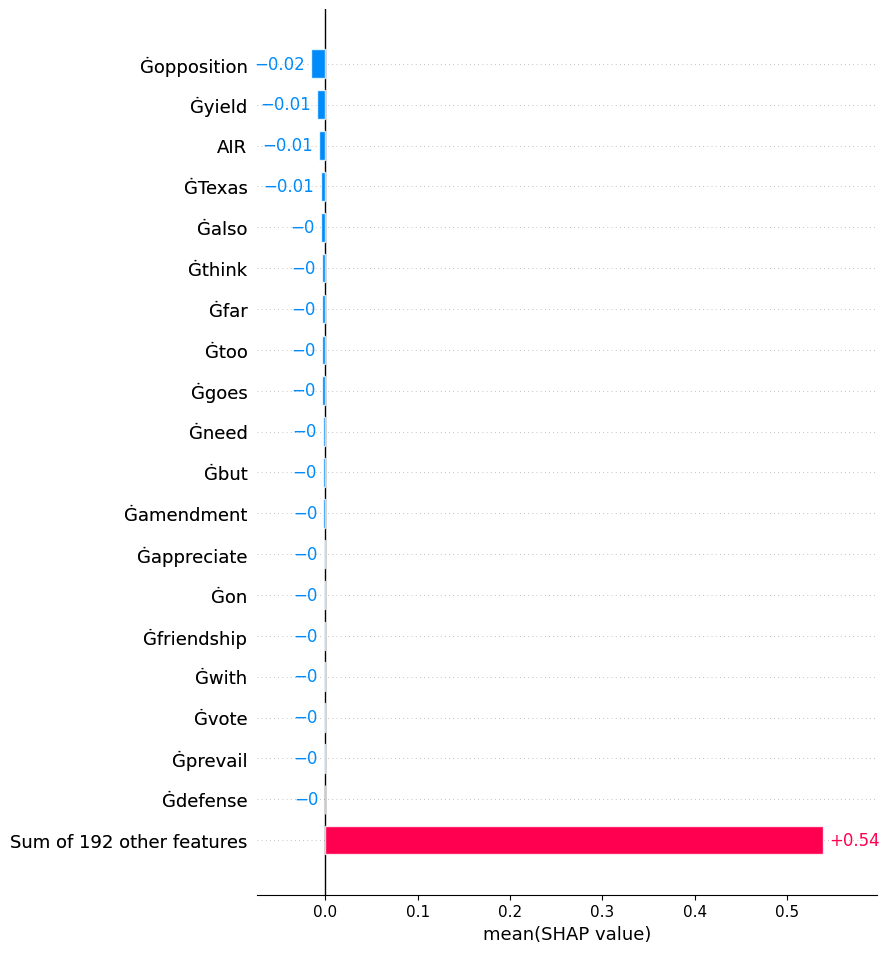

In [65]:
explainer.get_bar_plots_specific_class(shap_values, "R")

In [ ]:
explainer.get_bar_plots_for_specific_input(shap_values, 10, "R")

[{'label': 'D', 'score': 0.7101455330848694}, {'label': 'R', 'score': 0.2898545265197754}]
But we spent some 18 hours in committee. We considered hundreds of amendments. But the gentleman did not offer our committee, the Armed Services Committee, the opportunity to discuss this amendment.
D
----------------------
shap analysis
----------------------


`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

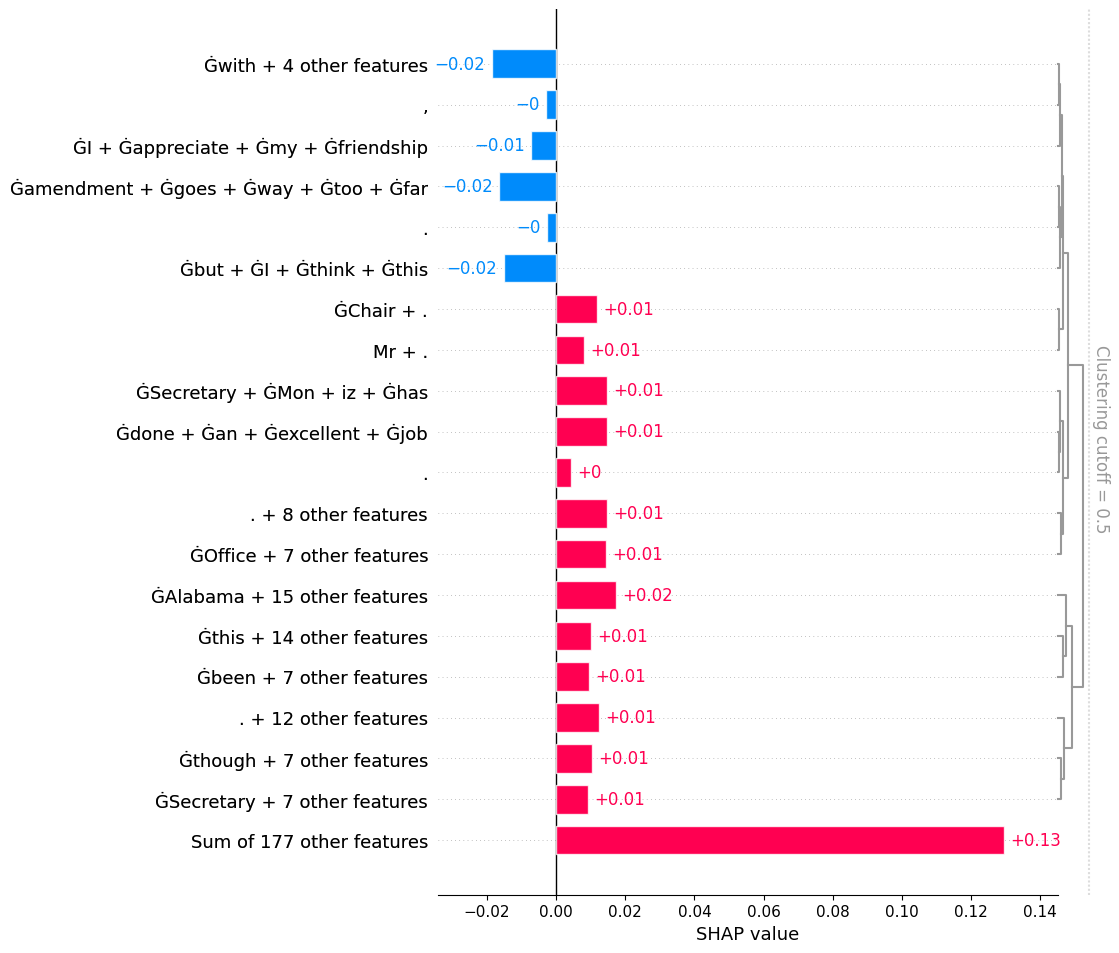

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

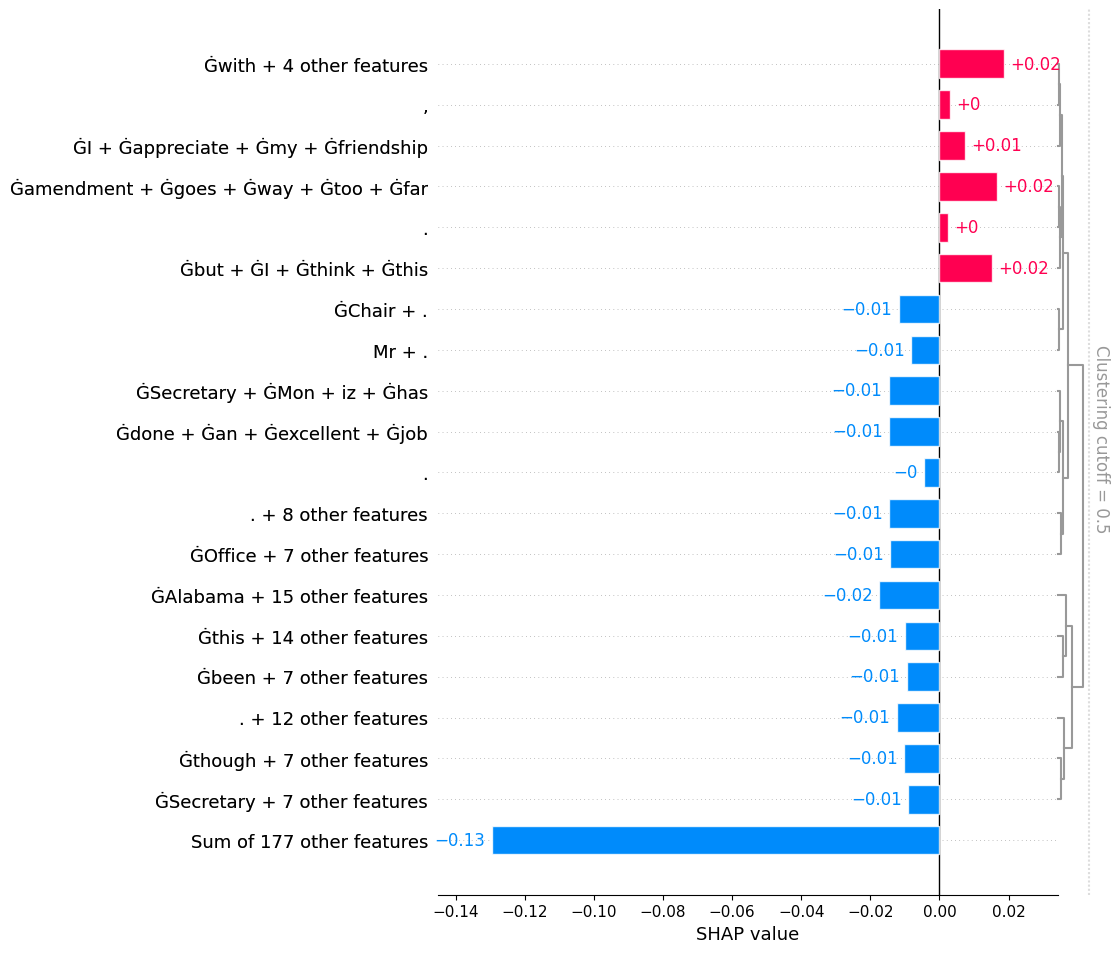

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

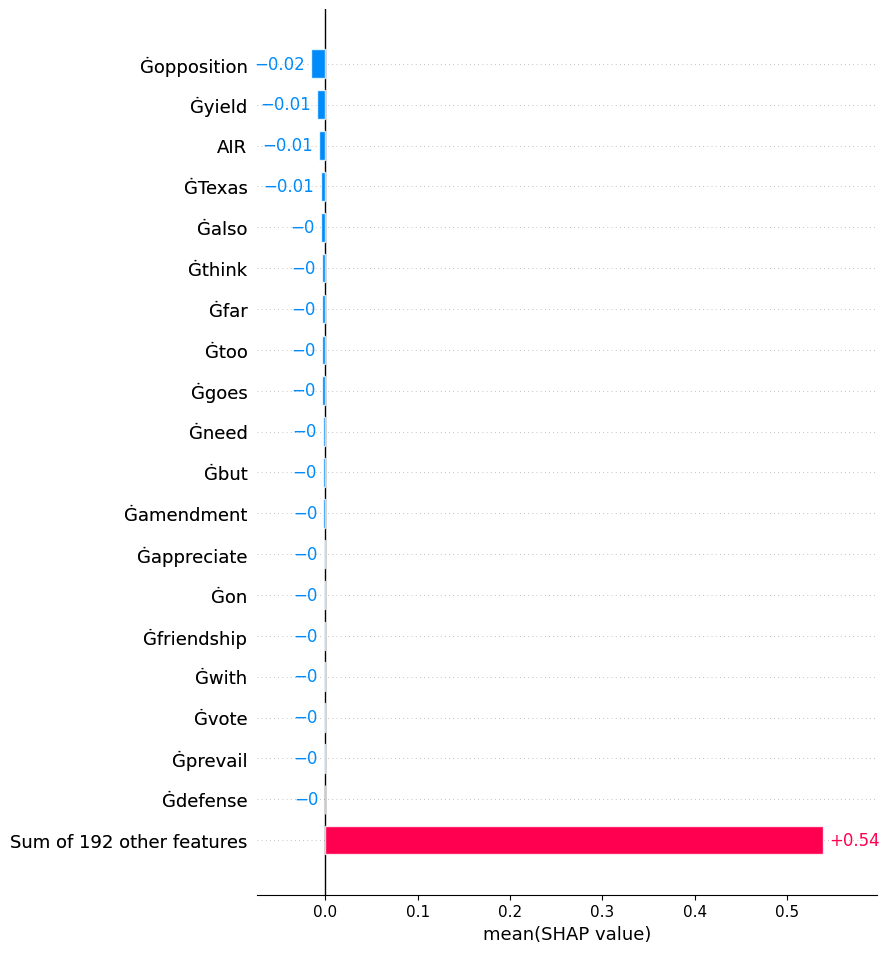

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/

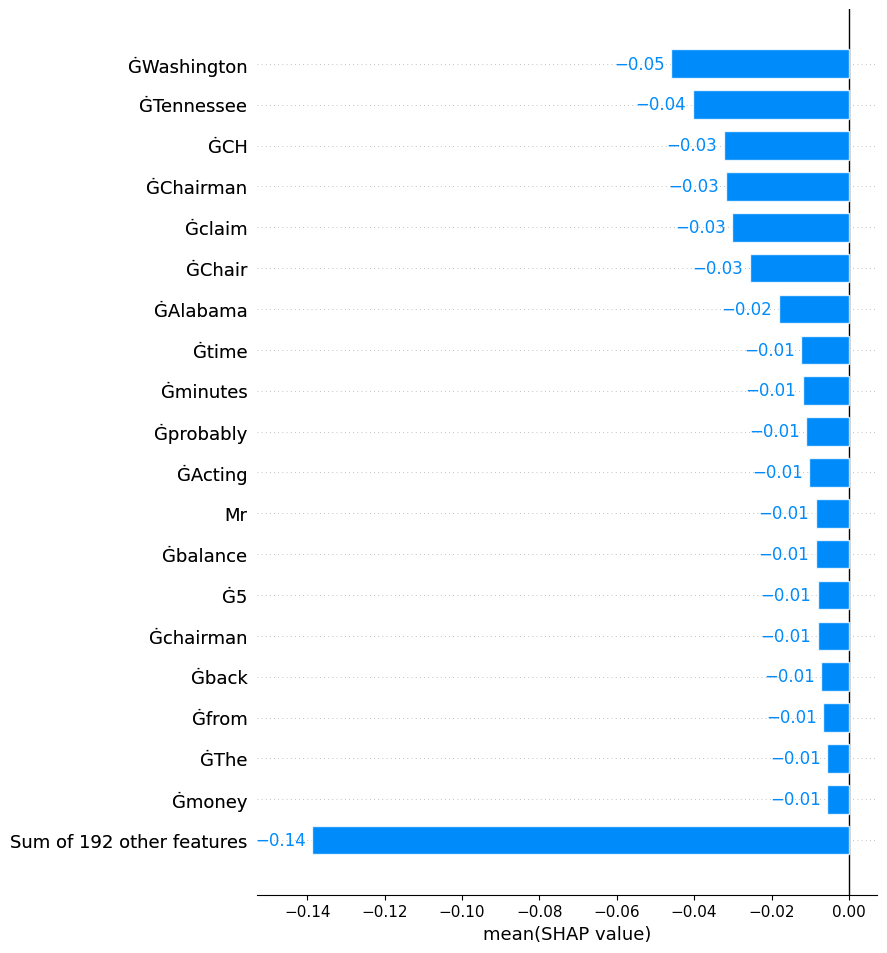

In [69]:
# wrong model prediction
idx = 2
print(model_predictions[idx])
print(arrow_dataset['text'][idx])
print(arrow_dataset['label'][idx])
print("----------------------")
print("shap analysis")
print("----------------------")
explainer.get_plots_specific_input(shap_values, idx, "R")
explainer.get_plots_specific_input(shap_values, idx, "D")
explainer.get_bar_plots_for_specific_input(shap_values, idx, "R")
explainer.get_bar_plots_for_specific_input(shap_values, idx, "D")
explainer.get_bar_plots_specific_class(shap_values, "R")
explainer.get_bar_plots_specific_class(shap_values, "D")

Rough work

In [ ]:
shap.initjs()
# shap.plots.bar(shap_values[:,:,"D"])
# shap.plots.bar(shap_values[:, :, "R"])
# shap.plots.bar(shap_values[:,:,"R"].mean(0))

# shap.plots.bar(shap_values[0, :, "R"])
shap.plots.force(shap_values[10, :, "D"])

In [ ]:
shap_values[0].shape

In [ ]:
# shap.plots.waterfall(shap_values[0])
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],
                                           shap_values[0], show=True)
# shap.summary_plot(shap_values[0], arrow_dataset['text'][s_ind:e_ind])


In [ ]:
shap.initjs()
# shap.summary_plot(shap_values, X, plot_type='bar')
# shap.force_plot(
#     explainer.expected_value, 
#     shap_values[-1:]
# )
# shap.force_plot(explainer.expected_value, plot_cmap="DrDb")
# shap.force_plot(explainer.expected_value[class_num], shap_values[class_num][input_num], x_test_words[input_num])
# shap.force_plot(explainer.expected_value[0], shap_values)
# Custom colors
positive_color = "#ca0020"
negative_color = "#92c5de"
shap.plots.force(explainer.expected_value,shap_values, 
                plot_cmap = [positive_color, negative_color])

In [ ]:
# Visualize the results (works in Jupyter or other IPython environments)

shap.plots.text(shap_values[0, :, :])
shap.plots.bar(shap_values[0, :, "LABEL_0"])

In [ ]:
shap.plots.text(shap_values)

In [ ]:
model

In [ ]:
from torch.utils.data import Dataset
import pandas as pd
import glob

class MovieReviewsDataset(Dataset):
  r"""PyTorch Dataset class for loading data.

  This is where the data parsing happens.

  This class is built with reusability in mind: it can be used as is as.

  Arguments:

    path (:obj:`str`):
        Path to the data partition.

  """

  def __init__(self, path, use_tokenizer):
    self.df = pd.DataFrame()
    files = glob.glob('../data/processed/hein-daily_114.csv') # Can use glob pattern here for multiple sessions
    for f in files:
      csv = pd.read_csv(f)
      self.df = self.df.append(csv)

  def __len__(self):
    r"""When used `len` return the number of examples.

    """
    
    return len(self.df)

  def __getitem__(self, item):
    r"""Given an index return an example from the position.
    
    Arguments:

      item (:obj:`int`):
          Index position to pick an example to return.

    Returns:
      :obj:`Dict[str, str]`: Dictionary of inputs that contain text and 
      asociated labels.

    """
    row = self.df.iloc[item]

    return {'text':row[0],
            'label':row[1]}



In [ ]:
# Create pytorch dataset.
train_dataset = MovieReviewsDataset(path='/content/aclImdb/train', 
                               use_tokenizer=tokenizer)
print('Created `train_dataset` with %d examples!'%len(train_dataset))


In [ ]:

(train_dataset.__getitem__(0))

In [ ]:
train_df = pd.DataFrame(columns = ['text', 'label'])

for i in range(35,45):
    new_row = pd.DataFrame(train_dataset.__getitem__(i), index=[i])
    # train_df.append(train_dataset.__getitem__(i),ignore_index=True)
    train_df = pd.concat([new_row,train_df.loc[:]]).reset_index(drop=True)

train_df

In [ ]:
from datasets import Dataset
arrow_dataset = Dataset.from_pandas(train_df)

In [ ]:
arrow_dataset['text'][:3]

In [ ]:
global model
model.eval()
speech = """
Thank you. Friends, colleagues, countrymen, and especially the people of Ohios Eighth Congressional District, thank you for sending me here. Let us today welcome all of the new Members and all of their families to what we all know to be a truly historic day. As we welcome all of the Members back who were reelected, we want to welcome your families as well, and I want to thank my family. I was doing pretty well on the walk over here from my ceremonial office until I ran into DEVIN NUNES three little girlsmy three biggest fansand one of them came running over and gave me a kiss, and I was a mess. This is the day the Lord has made. Let us rejoice and be glad. We rejoice that our new Members and families are here. We welcome them. We are glad and humbled to begin anew as servants of the peoples House. Here, it is our duty and our privilege to lend a willing ear to the people, to make laws in tune with their priorities and within the limits of their Constitution. In recent months, our economy has shown signs of improvement, and after difficult years, it may be a temptation to accept what I will call the new normal. But America did not become exceptional by ease. Far too many Americans remain out of work, and too many are working harder only to lose ground to stagnant wages and rising costs. We can do better. We can build an economy that furthers betterpaying jobs, more growth, and more opportunity for the Nations middle class. This is our vital task. We will begin this endeavor on common ground, both in letter and in spirit. It was actually my predecessor. Nicholas Longworth of Cincinnati, who changed the order of things so that all Members now take the oath of office at the same time. He called this innovation a timesaving device. He sounds like my kind of guy. But this shared ritual is no passing formality. It is a frontier where words end and where deeds begin. The pessimists dont see us crossing this channel. They say nothing is going to be accomplished here, that division is wider than ever and so gridlock will be even greater. Frankly, fair enough. Skepticism of our government is healthy and, in our time, quite understandable. But one problem with saying it cant be done is that it already has been doneor at least started. In the last Congress, this House passed a number of jobs bills with broad support from the majority and the minority, and we will begin our work on this common ground, taking up measures to develop North American energy, restore the hours of middle class workers, and help small businesses hire more of our veterans. We invite the President to support and sign these bipartisan initiatives into law. It will be a good start, and more, it will be a sign that the logjam is breaking, and it will be a foundation on which to address the bigger challenges in the pursuit of freedom and security. No, this wont be done in a tidy way. The battle of ideas never ends and, frankly, never should. As Speaker, all I askand, frankly, expectis that we disagree without being disagreeable. In return. I pledge to help each of you carry out your duties. My door, of course, is always open. Now dont get carried away with itall right -but it is always open. My colleagues, some things we do here will be characterized as shadowboxing and show business, but let me tell you and the American people, it is real work. It is a grind, as it should be, in striving to preserve the things that we all hold dear. Every day, you and I come out here, try to plant good seeds, cultivate the ground, and take care of the pests, and then, with patience and some sacrifice and Gods grace, there will be a harvest. Along the way, we may falter, but we Americans do not fall away from the task. We do not quit. So lets stand tall and prove the skeptics wrong. Lets make this a time of harvest, and may the fruits of our labors be ladders our children can use to climb the stairs to the stars. Thank you all, and God bless the United States of America. I am now ready to take the oath of office. I ask the Dean of the House of Representatives, the Honorable JOHN CONYERS of Michigan, to administer the oath of office."""

inputs = tokenizer(text=speech, return_tensors="pt", padding=True, truncation=True,  max_length=128).to(device)
print(inputs)
label_keys = {v: k for k, v in labels_ids.items()}
print(label_keys)
with torch.no_grad():
    logits = model(**inputs).logits
    print(logits)
    prob = torch.nn.functional.softmax(logits, dim=1)[0]
    agmax = logits.argmax().item()
    print(torch.max(prob))
    print(label_keys[logits.argmax().item()])

In [ ]:

# this defines an explicit python function that takes a list of strings and outputs scores for each class
def f(x):
    # print(x)
    tv = torch.tensor([tokenizer.encode(v, padding=True, max_length=128, truncation=True) for v in x])
    # print(f"tv",{tv})
    attention_mask = (tv!=0).type(torch.int64)
    # print(f"am",{attention_mask})
    outputs = model(tv,attention_mask=attention_mask)[0].detach().cpu().numpy()
    # print(f"ot",{type(outputs)})
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    # print(f"sc",{(scores)})
    val = sp.special.logit(scores)
    # print(val)
    return val


In [ ]:
def predict_fn(text):
    inputs = tokenizer(text=str(text), return_tensors="pt", padding=True, truncation=True,  max_length=128)
    # inputs = [tokenizer.encode(v, padding='max_length', max_length=128, truncation=True) for v in text]
    print(inputs)
    # label_keys = {v: k for k, v in labels_ids.items()}
    # print(label_keys)
    with torch.no_grad():
        logits = model(**inputs).logits
        prob = torch.nn.functional.softmax(logits, dim=1)[0]
        # agmax = logits.argmax().item()
        # print(prob)
        # return torch.max(prob)
        return prob

In [ ]:
method = "gpt2"
labels = ['R', 'D']
# build an explainer by passing a transformers tokenizer
if method == "gpt2":
    explainer = shap.Explainer(f, tokenizer, output_names=labels)

# build an explainer by explicitly creating a masker
elif method == "default-masker":
    masker = shap.maskers.Text(r"\W") # this will create a basic whitespace tokenizer
    explainer = shap.Explainer(f, masker, output_names=labels)

# build a fully custom tokenizer
elif method == "custom tokenizer":
    import re

    def custom_tokenizer(s, return_offsets_mapping=True):
        """ Custom tokenizers conform to a subset of the transformers API.
        """
        pos = 0
        offset_ranges = []
        input_ids = []
        for m in re.finditer(r"\W", s):
            start, end = m.span(0)
            offset_ranges.append((pos, start))
            input_ids.append(s[pos:start])
            pos = end
        if pos != len(s):
            offset_ranges.append((pos, len(s)))
            input_ids.append(s[pos:])
        out = {}
        out["input_ids"] = input_ids
        if return_offsets_mapping:
            out["offset_mapping"] = offset_ranges
        return out

    masker = shap.maskers.Text(custom_tokenizer)
    explainer = shap.Explainer(f, masker, output_names=labels)

In [ ]:
labels = ['R', 'D']
explainer = shap.Explainer(predict_fn, tokenizer, output_names=labels)
# shap_values = explainer(arrow_dataset[:len(arrow_dataset)])
shap_values = explainer(arrow_dataset['text'][0:1])

In [ ]:
labels = ['R', 'D']
# shap.waterfall_plot(shap_values[0][:, labels[preds[0]]], max_display=15)
shap.waterfall_plot(shap_values[2])

In [ ]:
shap.plots.text(shap_values)

In [ ]:
shap.plots.bar(shap_values[:,:,"R"].mean(0))

In [ ]:
arrow_dataset[9]

In [ ]:
shap.plots.bar(shap_values[2])

Lime Explaination

In [67]:
from lime.lime_text import LimeTextExplainer

class LimeTextClassification:
    "Explain text classification using LIME"

    def __init__(self,model,tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def predictor(self, text):
        "Party prediction function, here logits in tensor so we dtach it to convert into numpy"
        inputs = self.tokenizer(text=text, return_tensors="pt", padding=True, truncation=True,  max_length=128)
        outputs = self.model(**inputs)
        logits = outputs.logits

        prob = torch.nn.functional.softmax(logits, dim=1).detach().numpy()
        return prob


In [68]:
# arrow_dataset = arrow_dataset.to_pandas()

{'text': 'I ask unanimous consent that all Members have 5 legislative days within which to revise and extend their remarks and submit extraneous materials for the RECORD on H. R. 324. as amended, currently under consideration.',
 'label': 'R'}

In [72]:
import random
idx = random.randint(0,len(arrow_dataset))
idx

340

In [69]:

class_names = {0: 'R', 1:'D'}
lime_text_classifier = LimeTextClassification(model,tokenizer)

LIME_explainer = LimeTextExplainer(class_names=['R','D'])

idx = 124
text = arrow_dataset[idx]['text']
true_label = arrow_dataset[idx]['label']

LIME_exp = LIME_explainer.explain_instance(text, lime_text_classifier.predictor, num_features=20, num_samples=len(text.split()))

predicted_party = lime_text_classifier.predictor(text)
max_prob = predicted_party.max()
predicted_party = class_names[predicted_party.argmax().item()]

# print results
print('Document id: %d' % idx)
print('Speech text: ', text)
print('True party label: %s' % true_label)
print("------------------------------------------")
print('Probability of party =', max_prob.round(3))
print('Predicted party label: %s' % true_label)
print("------------------------------------------")
print()

LIME_exp.show_in_notebook(text=text)
# saving result in html
LIME_exp.save_to_file('lime_exp_{}.html'.format(idx))

Document id: 124
Speech text:  I ask unanimous consent that all Members have 5 legislative days within which to revise and extend their remarks and submit extraneous materials for the RECORD on H. R. 324. as amended, currently under consideration.
True party label: R
------------------------------------------
Probability of party = 0.915
Predicted party label: R
------------------------------------------



Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display


In [1]:
torch.cuda.empty_cache()

NameError: name 'torch' is not defined